In [56]:
import numpy as np
from data_loader import load_data
import random
import extendedQRNN
from visulize_results import *
import tensorflow as tf
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.models import model_from_json
from typhon.retrieval import qrnn
from data_loader import get_single_GPM_pass
import datetime
from typhon.retrieval import qrnn
from scipy.interpolate import griddata
import xarray
import cartopy.crs as ccrs
from data_loader import convertTimeStampToDatetime
from data_loader import *
from matplotlib.colors import LogNorm

In [38]:
folder_path = "/home/adriano/qrnn_precipitation_mensurments/results/CNN5/"

In [3]:
set_nmb = 1
newXData, newYData = load_data(set_nmb)
quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
input_dim = newXData.shape[1]

In [5]:
if set_nmb ==1:
    cut_index_1 =175000
    cut_index_2 = len(newYData)
elif set_nmb ==2:
    cut_index_1 =160000
    cut_index_2 = len(newYData)
elif set_nmb ==3:
    cut_index_1 =3100
    cut_index_2 = len(newYData)

In [6]:
xTest = newXData[cut_index_1:cut_index_2,:]
yTest = newYData[cut_index_1:cut_index_2]
xTrain = newXData[:cut_index_1,:]
yTrain = newYData[:cut_index_1]
input_dim = newXData.shape[1]

In the cell below the variable `x_mean` has not been defined. Would be the average of variable `newXData`?

In [9]:
for i in range(x_mean.shape[1]):
    print(x_sigma[0, i] - model.x_sigma[0, i])

NameError: name 'x_mean' is not defined

In [10]:
indexes = random.sample(range(0, len(xTrain)), len(xTrain))
x_val = xTrain[indexes[:20000]]
y_val = yTrain[indexes[:20000]]
x_train = xTrain[indexes[20000:]]
y_train = yTrain[indexes[20000:]]

Due to the large processing time, here I decrease the number of epochs.

In [19]:
model = extendedQRNN.QRNN((28 * 28 * 2 + 4,), quantiles, depth=8, width=256,
                          activation='relu', model_name='CNN')

model.fit(x_train=x_train,
          y_train=y_train[:, 3, 3],
          x_val=x_val,
          y_val=y_val[:, 3, 3],
          batch_size=512,
          maximum_epochs=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 2)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
__________

In [22]:
model.save('CNN_model_5epochs.h5')

In [30]:
y_pred = model.predict(xTest)

In [31]:
crps = model.crps(y_pred, yTest[:, 3, 3], np.array(quantiles))
print(crps)

(174370, 7)
(1, 7)
[ 0.00056166 -0.00060392  0.00162952 ...  0.0388639   0.00059673
  0.13805263]


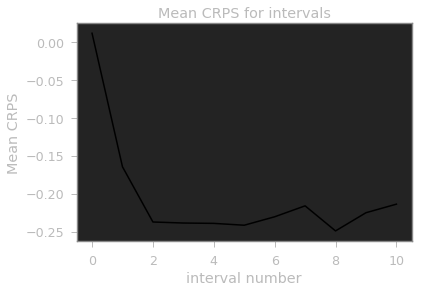

Mean CRPS:  -0.006025823328793658


In [34]:
generateCRPSIntervalPlot(crps, quantiles, yTest[:, 3, 3], y_pred, 1)
print('Mean CRPS: ', np.mean(crps))

In [36]:
print('calculate_tot_MSE: ', calculate_tot_MSE(newYData[:, 1], newYData[:, 0]))
print('correlation_target_prediction: ', correlation_target_prediction(newYData[:, 0], 
                                                                       newYData[:, 1]))

calculate_tot_MSE:  [1.62552086 1.71271335 1.76478646 1.62082373 1.65458695 1.67254017
 1.70007208]
correlation_target_prediction:  [0.5169641  0.5260603  0.46502907 0.4721165  0.43570261 0.48352832
 0.4755045 ]


(174370, 5)


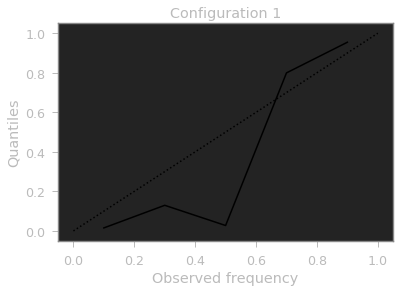

overall 0.45382965 
################## correlations ################
distance between 5 quantile and true vaule and label size: 0.9999949904028936
same as above but for the a priori mean as predictior : 0.9979189390312923
correlation target prediction: [0.23062094]
################# interval lengths #######
0.36310223501032285
####################### CRPS ########################
mean crps over the whole intevals: 0.07560858678274517
mean crps over the whole intevals: 0.0014709650404984133


In [39]:
generate_all_results(model, xTest, yTest[:, 3, 3], yTrain[:, 3, 3], quantiles,
                     True, folder_path, 'Configuration 1')

prediction:  [-0.01431259 -0.02115129 -0.00898467  0.14710775  2.390773  ]


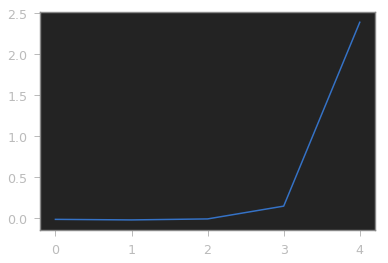

In [43]:
# row
prediction = np.load('./results/CNN5/predictions.npy')

sum_rain = np.sum(yTest, axis=(1, 2))
indexes = np.where(sum_rain > 400)[0]
index = indexes[10]

print('prediction: ', prediction[index, :])
plt.plot(prediction[index, :])

In [46]:
xData = np.load('trainingData/xDataC8C13S350000_R28_P200GPM_res3.npy')
yData = np.load('trainingData/yDataC8C13S350000_R28_P200GPM_res3.npy')
times = np.load('trainingData/timesC8C13S350000_R28_P200GPM_res3.npy')
distance = np.load('trainingData/distanceC8C13S350000_R28_P200GPM_res3.npy')

In the cell below, the data seems to have a different shape than expected.

In [47]:
nanValues = np.argwhere(np.isnan(xData))
xData = np.delete(xData, np.unique(nanValues[:, 0]), 0)
yData = np.delete(yData, np.unique(nanValues[:, 0]), 0)
times = np.delete(times, np.unique(nanValues[:, 0]), 0)
distance = np.delete(distance, np.unique(nanValues[:, 0]), 0)

max1 = xData[:, 0, :, :].max()
max2 = xData[:, 1, :, :].max()
min1 = xData[:, 0, :, :].min()
min2 = xData[:, 1, :, :].min()

max1 = np.mean(xData[:, 0, :, :])
max2 = np.mean(xData[:, 1, :, :])
min1 = np.std(xData[:, 0, :, :])
min2 = np.std(xData[:, 1, :, :])

mean1 = np.mean(xData[:, 0, :, :])
mean2 = np.mean(xData[:, 1, :, :])
std1 = np.std(xData[:, 0, :, :])
std2 = np.std(xData[:, 1, :, :])
x_test = np.zeros((3100, 112, 112, 2))
x_test[:, :, :, 0] = (xData[:3100, 0, 8:120, 8:120] - min1) / (max1 - min1)
x_test[:, :, :, 1] = (xData[:3100, 1, 8:120, 8:120] - min2) / (max2 - min2)

ValueError: could not broadcast input array from shape (3100,20,20) into shape (3100,112,112)

The variable `x_test` depends on the processing of the previous cell.

In [82]:
predictions = model.predict(x_test)
print(predictions.shape)
tmp_yTest = np.reshape(yTest,
                       (yTest.shape[0] * yTest.shape[1] * yTest.shape[2], 1))
tmp_predictions = np.reshape(predictions, (
predictions.shape[0] * predictions.shape[1] * predictions.shape[2],
predictions.shape[3]))
tmp_yTrain = np.reshape(yTrain, (
yTrain.shape[0] * yTrain.shape[1] * yTrain.shape[2], 1))

ValueError: operands could not be broadcast together with shapes (3100,112,112,2) (1,28,28,2) 

(2782, 3)


NameError: name 'predictions' is not defined

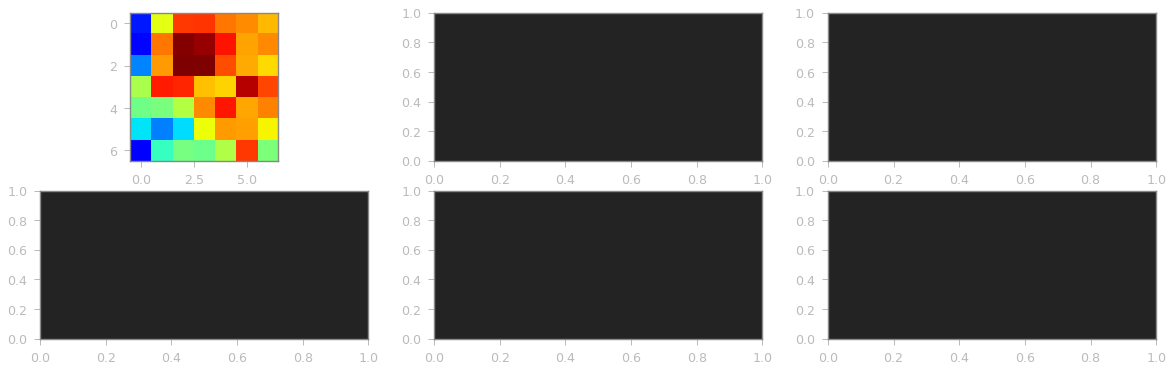

In [49]:
y_test = yData[:3100, :, :]
# %%
tmp = np.argwhere(yTest > 30)
print(tmp.shape)
# %%
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

index = tmp[0, 0]
fig, ax = plt.subplots(2, 3, figsize=(20, 6))
max_val = 50
min_val = 0.1
im1 = ax[0, 0].imshow(yTest[index, :, :], cmap='jet',
                      norm=LogNorm(vmin=0.1, vmax=max_val))
im2 = ax[0, 1].imshow(predictions[index, :, :, 0], cmap='jet',
                      norm=LogNorm(vmin=0.1, vmax=max_val))
im3 = ax[0, 2].imshow(predictions[index, :, :, 1], cmap='jet',
                      norm=LogNorm(vmin=0.1, vmax=max_val))
ax[1, 0].imshow(predictions[index, :, :, 2], cmap='jet',
                norm=LogNorm(vmin=0.1, vmax=max_val))
ax[1, 1].imshow(predictions[index, :, :, 3], cmap='jet',
                norm=LogNorm(vmin=0.1, vmax=max_val))
im6 = ax[1, 2].imshow(predictions[index, :, :, 4], cmap='jet',
                      norm=LogNorm(vmin=0.1, vmax=max_val))
cbar = fig.colorbar(im6, ax=ax, shrink=0.79, pad=0.025,
                    ticks=[min_val, 0.5, 1, 5, 10, 25, max_val])
cbar.ax.set_yticklabels([str(min_val), '0.5', '1', '5', '10', '25', str(100)])
cbar.set_label("Rain rate (mm/h)", fontsize=20)
cbar.ax.tick_params(labelsize=20)

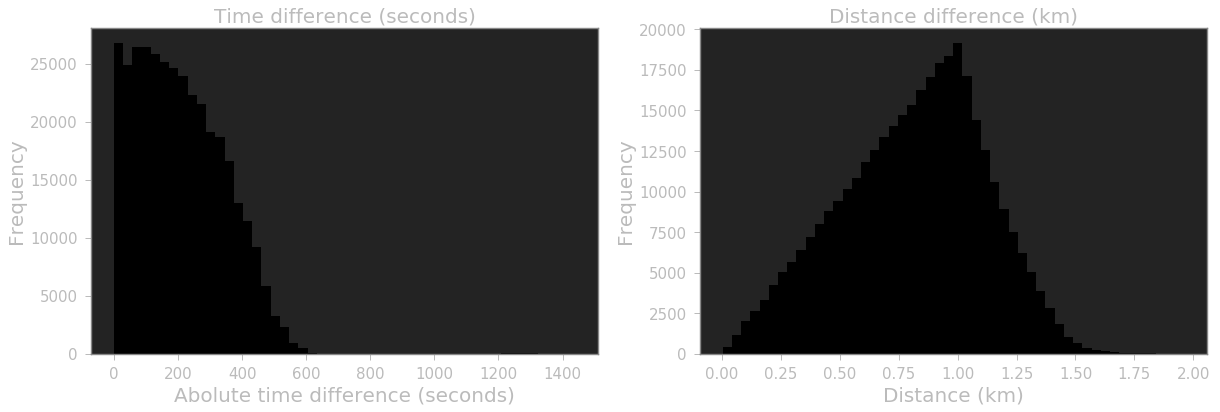

In [50]:
font1 = 20
font2 = 20
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].hist(np.abs(times[:, 0] - times[:, 1]), 50, color='black')
ax[0].set_title('Time difference (seconds)', fontsize=font2)
ax[0].set_ylabel('Frequency', fontsize=font1)
ax[0].set_xlabel('Abolute time difference (seconds)', fontsize=font1)
ax[0].tick_params(labelsize=15)

ax[1].hist(distance[:, 1] * 111, 50, color='black')
ax[1].set_title('Distance difference (km)', fontsize=font2)
ax[1].set_ylabel('Frequency', fontsize=font1)
ax[1].set_xlabel('Distance (km)', fontsize=font1)
ax[1].tick_params(labelsize=15)

The `C13_files.txt` file was not created. What is the content of this file, or in what context is it created by function `create_list_of_files(CHANNEL):`?

FileNotFoundError: [Errno 2] No such file or directory: 'C13_files.txt'

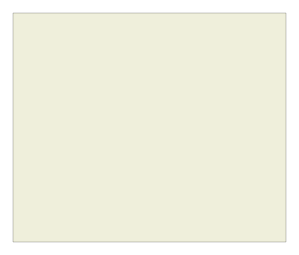

In [52]:
DATE = datetime.datetime(2019, 9, 5)
plot_predictions_and_labels(model, DATE, max1, max2, min1, min2)

In [53]:
perc_tot_rate, long, lat, time = get_single_GPM_pass(DATE)

The execution of the cell below also depends on the `C13_files.txt` file.

In [57]:
GPM_data = np.zeros((len(perc_tot_rate), 4))
GPM_data[:, 3] = perc_tot_rate
GPM_data[:, 0] = long
GPM_data[:, 1] = lat
GPM_data[:, 2] = time
receptiveField = 28
dataSize = len(perc_tot_rate)
xData = np.zeros((dataSize, receptiveField, receptiveField, 2))
times = np.zeros((dataSize, 3))
yData = np.zeros((dataSize, 1))
distance = np.zeros((dataSize, 2))

times[:, 0] = time
xData[:, :, :, 0], times[:, 1], distance[:, 0] = getGEOData(GPM_data, 'C13')
xData[:, :, :, 0] = (xData[:, :, :, 0] - min1) / (max1 - min1)

xData[:, :, :, 1], times[:, 2], distance[:, 1] = getGEOData(GPM_data, 'C08')
xData[:, :, :, 1] = (xData[:, :, :, 1] - min2) / (max2 - min2)

FileNotFoundError: [Errno 2] No such file or directory: 'C13_files.txt'

In [59]:
extent1 = [min(long), max(long), min(lat), max(lat)]
grid_x, grid_y = np.mgrid[extent1[0]:extent1[1]:200j,
                 extent1[2]:extent1[3]:200j]
points = np.zeros((len(lat), 2))
points[:, 0] = long
points[:, 1] = lat
values = perc_tot_rate

pred = model.predict(xData)
pred = np.square(pred)
max_val = max(max_val, pred.max())

There seems to be something wrong with the plots in the cell below.

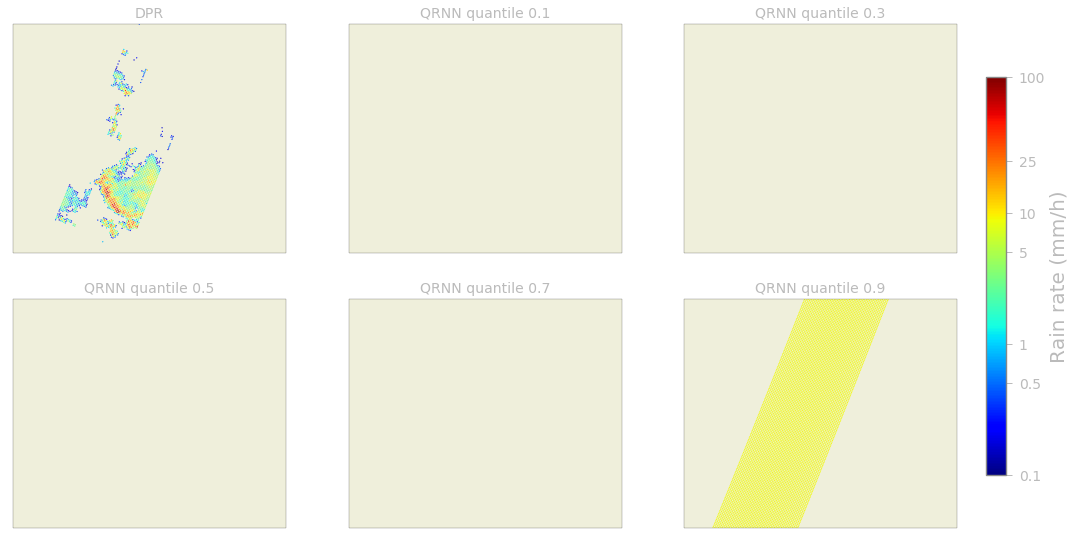

In [67]:
extent = [min(long), max(long), min(lat) + 2, max(lat) - 5]
axes = []
fig = plt.figure(figsize=(20, 25))

pc = ccrs.PlateCarree()
fig.tight_layout()
fig.subplots_adjust(bottom=0.60, left=0.0, right=0.8)
axes.append(fig.add_subplot(2, 3, 1, projection=pc))
axes[-1].set_extent(extent, crs=ccrs.PlateCarree())

axes[-1].coastlines(resolution='50m', color='black', linewidth=0.5)
# ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
axes[-1].add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)
axes[-1].add_feature(ccrs.cartopy.feature.OCEAN, zorder=0)
axes[-1].add_feature(ccrs.cartopy.feature.LAND, zorder=0)
min_val = 0.1
max_val = max(values)
inds = np.where(values > min_val)[0]
# grid_z0 = griddata(points,values, (grid_x, grid_y), method='linear')
# im = ax.imshow(grid_z0.T,extent=(extent1[0],extent1[1],extent1[2],extent1[3]), origin='lower')
im1 = axes[-1].scatter(long[inds], lat[inds], c=values[inds], s=1, cmap='jet',
                       norm=LogNorm(vmin=0.1, vmax=max_val))
axes[-1].set_title('DPR', fontsize=14)
quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]
for i in range(5):
    min_val = 0.1

    inds = np.where(pred[:, i] > min_val)[0]
    axes.append(fig.add_subplot(2, 3, i + 2, projection=pc))
    axes[-1].set_extent(extent, crs=ccrs.PlateCarree())

    axes[-1].coastlines(resolution='50m', color='black', linewidth=0.5)
    # ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
    axes[-1].add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)
    axes[-1].add_feature(ccrs.cartopy.feature.OCEAN, zorder=0)
    axes[-1].add_feature(ccrs.cartopy.feature.LAND, zorder=0)
    axes[-1].set_title('QRNN quantile %s' % (quantiles[i]), fontsize=14)

    # tmp = griddata(points,pred[:,i], (grid_x, grid_y), method='linear')
    # im =axes[-1].imshow(tmp.T,extent=(extent1[0],extent1[1],extent1[2],extent1[3]), origin='lower')
    im = axes[-1].scatter(long[inds], lat[inds], c=pred[inds, i], s=1,
                          cmap='jet',
                          norm=LogNorm(vmin=0.1, vmax=max_val))
    # plt.colorbar(im, ax=axes[-1])

cbar = fig.colorbar(im1, ax=axes, shrink=0.79, pad=0.025,
                    ticks=[min_val, 0.5, 1, 5, 10, 25, max_val])
cbar.ax.set_yticklabels([str(min_val), '0.5', '1', '5', '10', '25', str(100)])
cbar.set_label("Rain rate (mm/h)", fontsize=20)
cbar.ax.tick_params(labelsize=14)

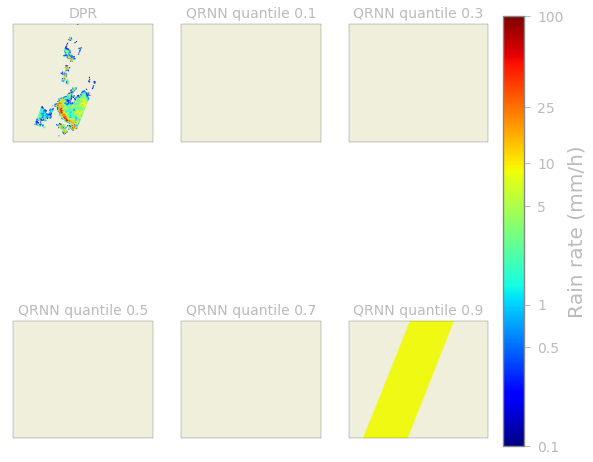

In [68]:
fig = plt.figure(figsize=(10, 27))
axes = []
# Generate an Cartopy projection
pc = ccrs.PlateCarree()
fig.tight_layout()
fig.subplots_adjust(bottom=0.60, left=0.0, right=0.8)
axes.append(fig.add_subplot(2, 3, 1, projection=pc))
axes[-1].set_extent(extent, crs=ccrs.PlateCarree())

axes[-1].coastlines(resolution='50m', color='black', linewidth=0.5)
# ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
axes[-1].add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)
axes[-1].add_feature(ccrs.cartopy.feature.OCEAN, zorder=0)
axes[-1].add_feature(ccrs.cartopy.feature.LAND, zorder=0)
quantiles = [0.1, 0.3, 0.5, 0.7, 0.9]

min_val = 0.1
max_val = max(values)
inds = np.where(values > min_val)[0]
# grid_z0 = griddata(points,values, (grid_x, grid_y), method='linear')
# im = ax.imshow(grid_z0.T,extent=(extent1[0],extent1[1],extent1[2],extent1[3]), origin='lower')
im1 = axes[-1].scatter(long[inds], lat[inds], c=values[inds], s=1, cmap='jet',
                       norm=LogNorm(vmin=0.1, vmax=max_val))
axes[-1].set_title('DPR', fontsize=14)

for i in range(5):
    min_val = 0.1

    inds = np.where(pred[:, i] > min_val)[0]
    axes.append(fig.add_subplot(2, 3, i + 2, projection=pc))
    axes[-1].set_extent(extent, crs=ccrs.PlateCarree())

    axes[-1].coastlines(resolution='50m', color='black', linewidth=0.5)
    # ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
    axes[-1].add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)
    axes[-1].add_feature(ccrs.cartopy.feature.OCEAN, zorder=0)
    axes[-1].add_feature(ccrs.cartopy.feature.LAND, zorder=0)
    axes[-1].set_title('QRNN quantile %s' % (quantiles[i]), fontsize=14)

    # tmp = griddata(points,pred[:,i], (grid_x, grid_y), method='linear')
    # im =axes[-1].imshow(tmp.T,extent=(extent1[0],extent1[1],extent1[2],extent1[3]), origin='lower')
    im = axes[-1].scatter(long[inds], lat[inds], c=pred[inds, i], s=1,
                          cmap='jet',
                          norm=LogNorm(vmin=0.1, vmax=max_val))
    # plt.colorbar(im, ax=axes[-1])

cbar = fig.colorbar(im1, ax=axes, shrink=0.79, pad=0.025,
                    ticks=[min_val, 0.5, 1, 5, 10, 25, max_val])
cbar.ax.set_yticklabels([str(min_val), '0.5', '1', '5', '10', '25', str(100)])
cbar.set_label("Rain rate (mm/h)", fontsize=20)
cbar.ax.tick_params(labelsize=14)

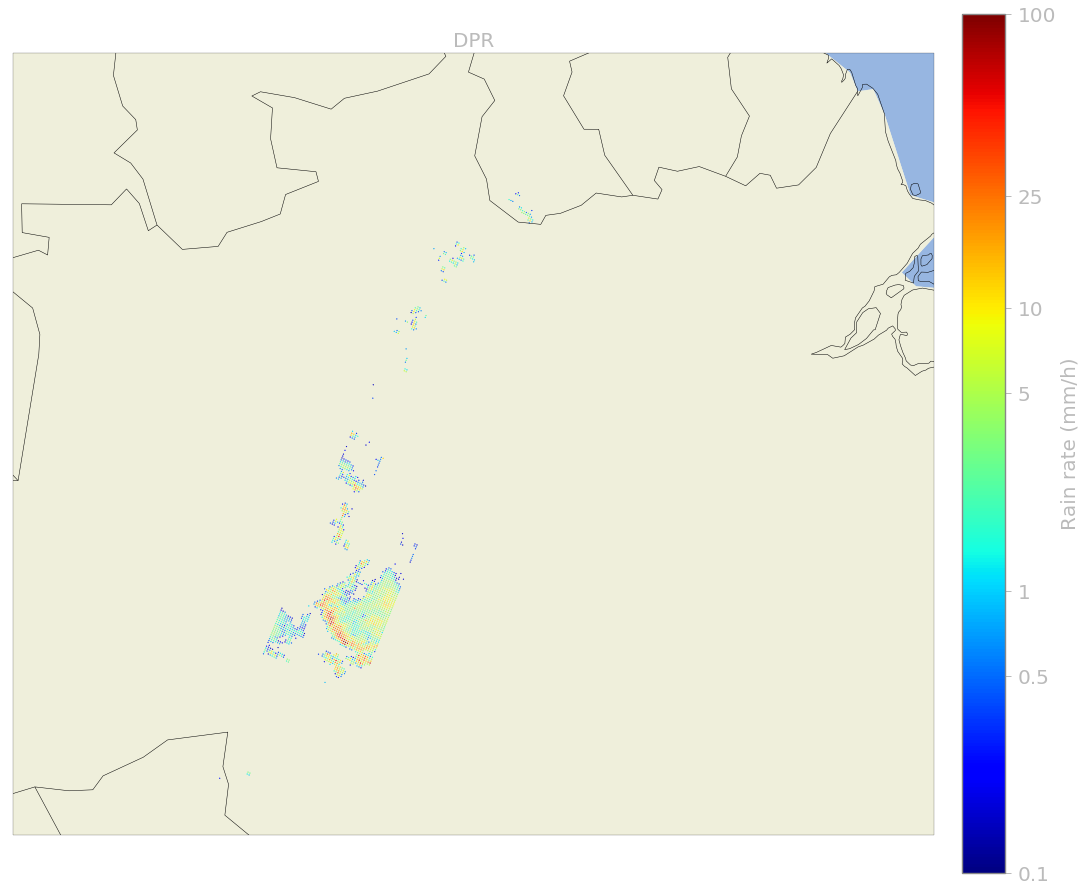

In [69]:
maxLongitude = -51
minLongitde = -70
maxLatitide = 2.5
minLatitude = -11
extent = [-45, -75, 7.5, -16]

DATE = datetime.datetime(2019, 9, 5)
plotGPMData(DATE)

In [70]:
xData = np.load('trainingData/xDataC8C13S350000_R28_P200GPM_res3.npy')
yData = np.load('trainingData/yDataC8C13S350000_R28_P200GPM_res3.npy')
times = np.load('trainingData/timesC8C13S350000_R28_P200GPM_res3.npy')
distance = np.load('trainingData/distanceC8C13S350000_R28_P200GPM_res3.npy')

In [71]:
index = 1
t = np.sum(yData, axis=(1, 2))
print(t.shape)
tmp = np.argwhere(t > 20000)
print(tmp.shape)

(350000,)
(0, 1)


The vaiable `tmp` seems to have less dimensions than the expected.

IndexError: index 3 is out of bounds for axis 0 with size 0

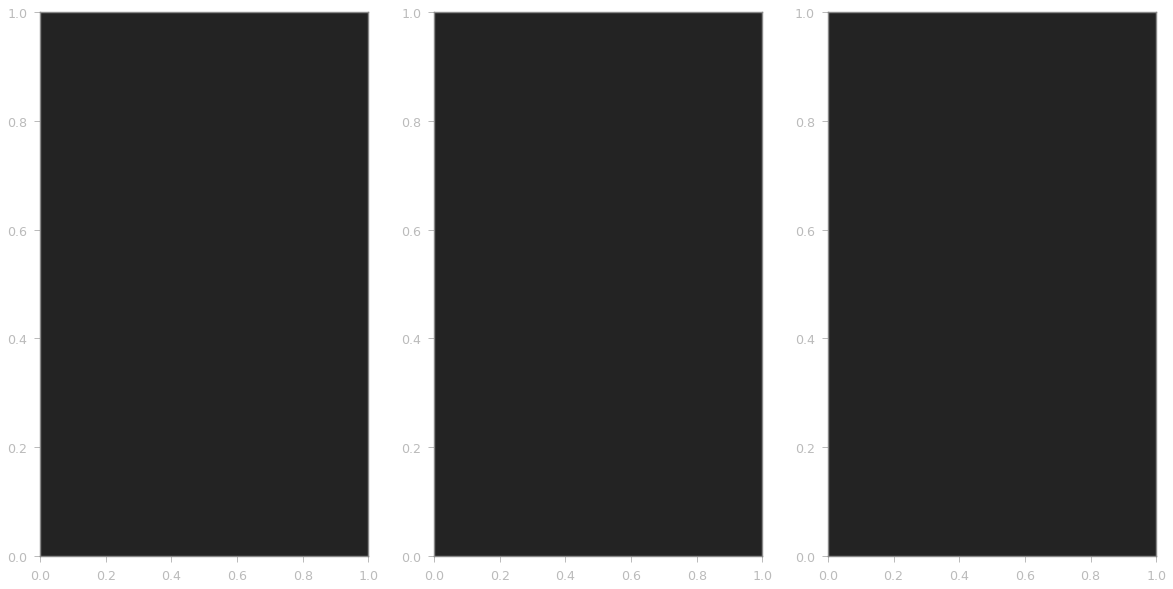

In [72]:
fig = plt.figure(figsize=(20, 10))

axes = []
axes.append(fig.add_subplot(1, 3, 1))
axes.append(fig.add_subplot(1, 3, 2))
axes.append(fig.add_subplot(1, 3, 3))
# 3
index = tmp[3, 0]
cmin = 0.1
cmax = 200
t = (xData[index, 0, :, :] - xData[index, 0, :, :].min()) / (
            xData[index, 0, :, :].max() - xData[index, 0, :, :].min())

# im2 = axes[0].imshow(xData[index,0,:,:],cmap='jet',
#                       norm = LogNorm(vmin=0.1, vmax = 500))

im2 = axes[0].imshow(xData[index, 0, :, :], norm=LogNorm(), cmap='cubehelix')
axes[0].set_title('Channel 13', fontsize=17)

cbar = fig.colorbar(im2, ax=axes[0], shrink=0.50, pad=0.05,
                    ticks=[0.1, 0.5, 1, 5, 10, 25, 50])
cbar.ax.set_yticklabels([str(0.1), '0.5', '1', '5', '10', '25', '50'])
cbar.set_label("Brightness temperature (K)", fontsize=17)
cbar.ax.tick_params(labelsize=17)

im3 = axes[1].imshow(xData[index, 1, :, :], norm=LogNorm(), cmap='cubehelix')
cbar = fig.colorbar(im3, ax=axes[1], shrink=0.50, pad=0.05,
                    ticks=[0.1, 0.5, 1, 2])
cbar.ax.set_yticklabels([str(0.1), '0.5', '1', '2'])
cbar.set_label("Brightness temperature (K)", fontsize=17)
cbar.ax.tick_params(labelsize=17)
axes[1].set_title('Channel 8', fontsize=17)

im1 = axes[2].imshow(yData[index, :, :], cmap='jet',
                     norm=LogNorm(vmin=0.1, vmax=100))
cbar = fig.colorbar(im1, ax=axes[2], shrink=0.50, pad=0.05,
                    ticks=[0.1, 0.5, 1, 5, 10, 25, 100])
cbar.ax.set_yticklabels([str(0.1), '0.5', '1', '5', '10', '25', str(100)])
cbar.set_label("Rain rate (mm/h)", fontsize=17)
cbar.ax.tick_params(labelsize=17)
axes[2].set_title('2BCMB', fontsize=17)

Problems with `C13_files.txt` files again.

In [74]:
getReferenceData()

File does not exist, downloading
contents of URL written to 2B.GPM.DPRGMI.CORRA2018.20190320-S055548-E072822.028727.V06A.HDF5
File does not exist, downloading
contents of URL written to 2B.GPM.DPRGMI.CORRA2018.20190320-S072823-E090057.028728.V06A.HDF5
File does not exist, downloading
contents of URL written to 2B.GPM.DPRGMI.CORRA2018.20190320-S090058-E103333.028729.V06A.HDF5
10000
File does not exist, downloading
contents of URL written to 2B.GPM.DPRGMI.CORRA2018.20190320-S103334-E120608.028730.V06A.HDF5
File does not exist, downloading
contents of URL written to 2B.GPM.DPRGMI.CORRA2018.20190320-S120609-E133843.028731.V06A.HDF5
File does not exist, downloading
contents of URL written to 2B.GPM.DPRGMI.CORRA2018.20190320-S133844-E151118.028732.V06A.HDF5
File does not exist, downloading
contents of URL written to 2B.GPM.DPRGMI.CORRA2018.20190320-S151119-E164354.028733.V06A.HDF5
File does not exist, downloading
contents of URL written to 2B.GPM.DPRGMI.CORRA2018.20190320-S164355-E181628.028

FileNotFoundError: [Errno 2] No such file or directory: 'C13_files.txt'

In [75]:
scalexData = np.load('trainingData/xDataC8C13S350000_R28_P200GPM_res3.npy')
scaleyData = np.load('trainingData/yDataC8C13S350000_R28_P200GPM_res3.npy')
scaletimes = np.load('trainingData/timesC8C13S350000_R28_P200GPM_res3.npy')
scaledistance = np.load('trainingData/distanceC8C13S350000_R28_P200GPM_res3.npy')

In [76]:
scalenanValues = np.argwhere(np.isnan(scalexData))
scalexData = np.delete(scalexData, np.unique(scalenanValues[:, 0]), 0)

In the next two cells the vaiable `tmpXData` seems to have different dimensions than expected.

In [77]:
tmpXData = np.zeros(
    (len(xData), xData.shape[2], xData.shape[3], xData.shape[1]))
for i in range(xData.shape[1]):
    mean1 = np.mean(xData[:, i, :, :])
    std1 = np.std(xData[:, i, :, :])
    xData[:, i, :, :] = (xData[:, i, :, :] - mean1) / std1

tmpXData = preprocessDataForTraining(xData, yData, times, distance)
predictions = model.predict()

ValueError: operands could not be broadcast together with shapes (350000,1572) (1,28,28,2) 

In [78]:
mean = np.zeros((len(tmpXData), 1))
for i in range(len(tmpXData)):
    mean[i] = model.sample_posterior(tmpXData[i, :])

ValueError: operands could not be broadcast together with shapes (1572,) (1,28,28,2) 

In [79]:
print(calculate_tot_MSE(mean, yData[:, 0]))
print(calculate_tot_MAE(mean, yData[:, 0]))
print(calculate_bias(mean, yData[:, 0]))
print(correlation_target_prediction(yData[:, 0], mean))

[2.10579272 2.28297907 2.12677629 2.00282805 1.90173812 2.08570124
 2.07229884]
[0.18989511 0.19127735 0.18913099 0.18544227 0.18517601 0.1859672
 0.18631173]
-0.1876000944540528
[nan nan nan nan nan nan nan]


/home/adriano/qrnn_precipitation_mensurments/visulize_results.py:1037: RuntimeWarning: invalid value encountered in true_divide
  return (exy/len(prediction)-ex/len(prediction)*yTest.sum()/len(prediction))/(np.std(yTest)*np.std(prediction[:]))


In [80]:
print(calculate_tot_MSE(yData[:, 1], yData[:, 0]))
print(calculate_tot_MAE(yData[:, 1], yData[:, 0]))
print(calculate_bias(yData[:, 1], yData[:, 0]))
print(correlation_target_prediction(yData[:, 0], yData[:, 1]))

[1.62394241 1.71106525 1.76223326 1.61927028 1.65261037 1.67052624
 1.69847656]
[0.16133388 0.16245703 0.16195934 0.15820012 0.15869132 0.16002588
 0.16001144]
0.0008719911544047831
[0.51679243 0.52592369 0.46489032 0.47247019 0.43561174 0.48336574
 0.47535364]


I believe that the error in the cell below may be associated with processing the data from the previous two cells.

ValueError: c of shape (10000, 7) not acceptable as a color sequence for x with size 0, y with size 0

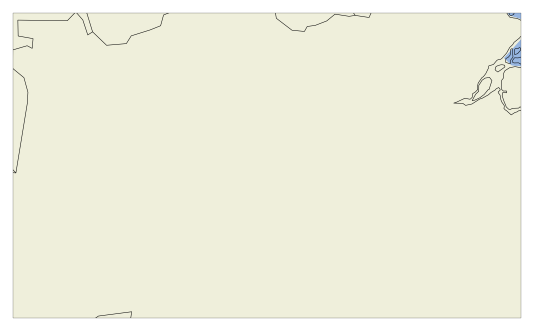

In [81]:
extent = [-70, -50, -10, 2]
fig = plt.figure(figsize=(30, 30))
axes = []
start_index = 20000
end_index = 30000
# Generate an Cartopy projection
pc = ccrs.PlateCarree()
fig.tight_layout()
fig.subplots_adjust(bottom=0.60, left=0.0, right=0.8)
axes.append(fig.add_subplot(1, 3, 1, projection=pc))
axes[-1].set_extent(extent, crs=ccrs.PlateCarree())

axes[-1].coastlines(resolution='50m', color='black', linewidth=0.5)
# ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
axes[-1].add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)
axes[-1].add_feature(ccrs.cartopy.feature.OCEAN, zorder=0)
axes[-1].add_feature(ccrs.cartopy.feature.LAND, zorder=0)

min_val = 0.1
max_val = 100

im1 = axes[-1].scatter(GPM_data[start_index:end_index, 0],
                       GPM_data[start_index:end_index, 1],
                       c=yData[start_index:end_index, 0], s=1, cmap='jet',
                       norm=LogNorm(vmin=min_val, vmax=max_val))
axes[-1].set_title('DPR', fontsize=20)

axes.append(fig.add_subplot(1, 3, 2, projection=pc))
axes[-1].set_extent(extent, crs=ccrs.PlateCarree())

axes[-1].coastlines(resolution='50m', color='black', linewidth=0.5)
# ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
axes[-1].add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)
axes[-1].add_feature(ccrs.cartopy.feature.OCEAN, zorder=0)
axes[-1].add_feature(ccrs.cartopy.feature.LAND, zorder=0)

im1 = axes[-1].scatter(GPM_data[start_index:end_index, 0],
                       GPM_data[start_index:end_index, 1],
                       c=yData[start_index:end_index, 1], s=1, cmap='jet',
                       norm=LogNorm(vmin=min_val, vmax=max_val))
axes[-1].set_title('HE', fontsize=20)

axes.append(fig.add_subplot(1, 3, 3, projection=pc))
axes[-1].set_extent(extent, crs=ccrs.PlateCarree())

axes[-1].coastlines(resolution='50m', color='black', linewidth=0.5)
# ax.add_feature(ccrs.cartopy.feature.STATES, linewidth=0.5)
axes[-1].add_feature(ccrs.cartopy.feature.BORDERS, linewidth=0.5)
axes[-1].add_feature(ccrs.cartopy.feature.OCEAN, zorder=0)
axes[-1].add_feature(ccrs.cartopy.feature.LAND, zorder=0)

tmp_pred = predictions[start_index:end_index, 2]
tmp_gpm = GPM_data[start_index:end_index, :]
inds = np.where(tmp_pred > min_val)[0]

im1 = axes[-1].scatter(tmp_gpm[inds, 0], tmp_gpm[inds, 1], c=tmp_pred[inds],
                       s=1, cmap='jet',
                       norm=LogNorm(vmin=min_val, vmax=max_val))
axes[-1].set_title('QRNN', fontsize=20)
# plt.colorbar(im, ax=ax)


# plt.colorbar(im, ax=axes[-1])

cbar = fig.colorbar(im1, ax=axes, shrink=0.79, pad=0.025,
                    ticks=[min_val, 0.5, 1, 5, 10, 25, max_val])
cbar.ax.set_yticklabels(
    [str(min_val), '0.5', '1', '5', '10', '25', str(max_val)])
cbar.set_label("Rain rate (mm/h)", fontsize=20)
cbar.ax.tick_params(labelsize=20)